In [1]:
%%time
import os
if not os.path.exists('CSRNet-pytorch/'):
    !pip install -qU scipy torch_snippets torch_summary
    !git clone https://github.com/sizhky/CSRNet-pytorch.git
    
%cd CSRNet-pytorch
!ln -s ../shanghaitech_with_people_density_map
from torch_snippets import *
import h5py
from scipy import io

Cloning into 'CSRNet-pytorch'...
remote: Enumerating objects: 92, done.
remote: Total 92 (delta 0), reused 0 (delta 0), pack-reused 92
Receiving objects: 100% (92/92), 623.74 KiB | 29.70 MiB/s, done.
Resolving deltas: 100% (51/51), done.
/kaggle/working/CSRNet-pytorch


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


CPU times: user 5.92 s, sys: 1.17 s, total: 7.09 s
Wall time: 32.9 s


In [2]:
part_A = Glob('/kaggle/input/shanghaitech-with-people-density-map/ShanghaiTech/part_A/train_data')
image_folder = '/kaggle/input/shanghaitech-with-people-density-map/ShanghaiTech/part_A/train_data/images'
heatmap_folder = '/kaggle/input/shanghaitech-with-people-density-map/ShanghaiTech/part_A/train_data/ground-truth-h5'
gt_folder = '/kaggle/input/shanghaitech-with-people-density-map/ShanghaiTech/part_A/train_data/ground-truth'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
tfm = T.Compose([
    T.ToTensor()
])

In [4]:
class Crowds(Dataset):
    def __init__(self, stems):
        self.stems = stems
        
    def __len__(self):
        return len(self.stems)
    
    def __getitem__(self, ix):
        _stem = self.stems[ix]
        image_path = f"{image_folder}/{_stem}.jpg"
        heatmap_path = f"{heatmap_folder}/{_stem}.h5"
        gt_path = f"{gt_folder}/GT_{_stem}.mat"
        
        pts = io.loadmat(gt_path)
        pts = len(pts['image_info'][0, 0][0, 0][0])
        
        image = read(image_path, 1)
        with h5py.File(heatmap_path, 'r') as hf:
            gt = hf['density'][:]
        gt = resize(gt, 1/8) * 64
        return image.copy(), gt.copy(), pts
    
    def collate_fn(self, batch):
        ims, gts, pts = list(zip(*batch))
        ims = torch.cat([tfm(im)[None] for im in ims]).to(device)
        gts = torch.cat([tfm(gt)[None] for gt in gts]).to(device)
        return ims, gts, torch.tensor(pts).to(device)
    
    def choose(self):
        return self[randint(len(self))]

In [5]:
from sklearn.model_selection import train_test_split

train_stems, valid_stems = train_test_split(stems(Glob(image_folder)))
train_ds, valid_ds = Crowds(train_stems), Crowds(valid_stems)
train_dl = DataLoader(train_ds, batch_size=1, shuffle=True, collate_fn=train_ds.collate_fn)
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=True, collate_fn=valid_ds.collate_fn)

In [6]:
import torch
import torch.nn as nn
from torchvision import models
from utils import save_net, load_net

In [7]:
def make_layers(cfg, in_channels=3, batch_norm=False, dilation=False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate, dilation=d_rate)
            
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [8]:
class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super().__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat = [512, 512, 512, 256, 128, 64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat, in_channels=512, dilation=True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        if not load_weights:
            mod = models.vgg16(pretrained=True)
            self._initialize_weights()
            items = list(self.frontend.state_dict().items())
            _items = list(mod.state_dict().items())
            for i in range(len(self.frontend.state_dict().items())):
                items[i][1].data[:] = _items[i][1].data[:]
        
    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

In [9]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    ims, gts, pts = data
    _gts = model(ims)
    loss = criterion(_gts, gts)
    loss.backward()
    optimizer.step()
    pts_loss = nn.L1Loss()(_gts.sum(), gts.sum())
    return loss.item(), pts_loss.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, gts, pts = data
    _gts = model(ims)
    loss = criterion(_gts, gts)
    pts_loss = nn.L1Loss()(_gts.sum(), gts.sum())
    return loss.item(), pts_loss.item()

In [10]:
model = CSRNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)
n_epochs = 20

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(train_dl)
    for bx, data in enumerate(train_dl):
        loss, pts_loss = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_pts_loss=pts_loss, end='\r')
    
    N = len(valid_dl)
    for bx, data in enumerate(valid_dl):
        loss, pts_loss = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_pts_loss=pts_loss, end='\r')
        
    log.report_avgs(ex+1)
    if ex==10:
        optimizer = optim.Adam(model.parameters(), lr=1e-7)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 73.1MB/s] 


EPOCH: 1.000  val_pts_loss: 297.269  val_loss: 0.050  trn_pts_loss: 442.506  trn_loss: 0.052  (57.87s - 1099.51s remaining)
EPOCH: 2.000  val_pts_loss: 276.537  val_loss: 0.042  trn_pts_loss: 317.735  trn_loss: 0.043  (108.04s - 972.35s remaining)
EPOCH: 3.000  val_pts_loss: 202.038  val_loss: 0.041  trn_pts_loss: 232.474  trn_loss: 0.038  (158.58s - 898.64s remaining)
EPOCH: 4.000  val_pts_loss: 180.630  val_loss: 0.037  trn_pts_loss: 155.831  trn_loss: 0.035  (208.49s - 833.97s remaining)
EPOCH: 5.000  val_pts_loss: 174.375  val_loss: 0.036  trn_pts_loss: 146.788  trn_loss: 0.033  (258.24s - 774.71s remaining)
EPOCH: 6.000  val_pts_loss: 154.846  val_loss: 0.035  trn_pts_loss: 141.707  trn_loss: 0.033  (307.76s - 718.10s remaining)
EPOCH: 7.000  val_pts_loss: 156.341  val_loss: 0.034  trn_pts_loss: 137.571  trn_loss: 0.032  (357.34s - 663.63s remaining)
EPOCH: 8.000  val_pts_loss: 150.859  val_loss: 0.035  trn_pts_loss: 131.948  trn_loss: 0.031  (407.00s - 610.50s remaining)
EPOCH: 9

100%|██████████| 121/121 [00:00<00:00, 532.68it/s]


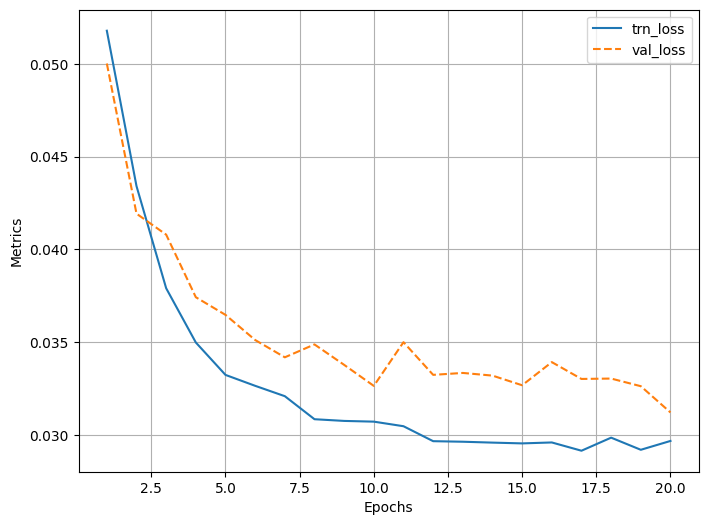

In [11]:
log.plot_epochs(['trn_loss', 'val_loss'])

In [12]:
from matplotlib import cm as c
from torchvision import datasets, transforms
from PIL import Image

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_folder = '/kaggle/input/shanghaitech-with-people-density-map/ShanghaiTech/part_A/test_data/'
imgs = Glob(f"{test_folder}/images")
f = choose(imgs)
print(f)
img = transform(Image.open(f).convert('RGB')).to(device)

/kaggle/input/shanghaitech-with-people-density-map/ShanghaiTech/part_A/test_data/images/IMG_147.jpg

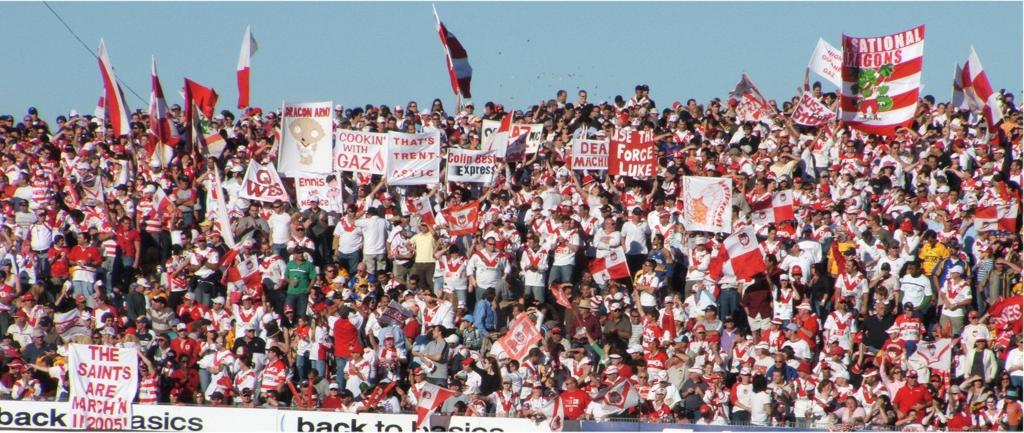

In [13]:
Image.open(f)

Predicted Count:  344

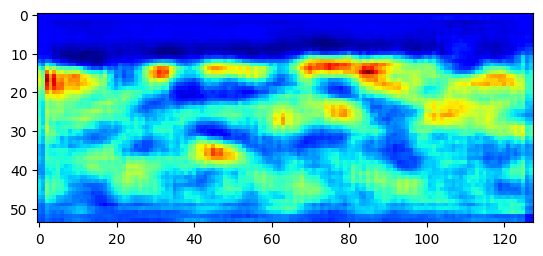

In [14]:
output = model(img[None])
print("Predicted Count: ", int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2], output.detach().cpu().shape[3]))
plt.imshow(temp, cmap=c.jet)
plt.show()

In [15]:
model

CSRNet(
  (frontend): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [16]:
file_path = '/kaggle/working/model.pth'
torch.save(model, file_path)
torch.save(model.state_dict(), '/kaggle/working/model_params.pth')

In [17]:
loaded_model = torch.load(file_path)
loaded_model = CSRNet()
loaded_model.load_state_dict(torch.load('/kaggle/working/model_params.pth'))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>